In [1]:
import requests

In [2]:
# This gives information for each station that remains stable over time
url_stations = 'https://gbfs.citibikenyc.com/gbfs/en/station_information.json'

In [3]:
# This gives the live status of all the stations (e.g., bikes available etc)
url_status = 'https://gbfs.citibikenyc.com/gbfs/en/station_status.json'

In [4]:
# We fetch for now just the time-invariant data
results = requests.get(url_stations).json() 

In [5]:
# We only need a subset of the data in the JSON returned by the Citibike API, so we keep only what we need
stations = results["data"]["stations"]

In [6]:
# We will not be using dataframes for this insertion task. (See the G2 notebook if you want to use Pandas)
# We just put the data in a dataframe to understand what is going on.
import pandas as pd
df_stations = pd.DataFrame(stations)
df_stations.head(5)

,capacity,eightd_has_key_dispenser,eightd_station_services,external_id,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id
0,33,True,[{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a'...,66db6da2-0aca-11e7-82f6-3863bb44ef7c,True,40.704633,-74.013617,Broadway & Battery Pl,71.0,"[CREDITCARD, KEY]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,4962.01,304
1,53,False,[{'id': '2e104e31-606a-44af-8b25-ceaffc338489'...,66dbc982-0aca-11e7-82f6-3863bb44ef7c,True,40.755103,-73.974987,E 47 St & Park Ave,71.0,"[CREDITCARD, KEY]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6584.12,359
2,39,False,[{'id': '37a1ae1b-3dd6-4876-8c57-572aaac97981'...,66dbf0d0-0aca-11e7-82f6-3863bb44ef7c,True,40.740343,-73.989551,Broadway & E 22 St,71.0,"[CREDITCARD, KEY]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6098.07,402
3,19,False,[{'id': '9fb74cf0-b08b-4983-ae0e-be909fc28bc3'...,66ddbd20-0aca-11e7-82f6-3863bb44ef7c,True,40.750585,-73.994685,8 Ave & W 31 St,71.0,"[CREDITCARD, KEY]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6450.05,3255
4,41,False,[{'id': '286d75b2-088f-4a79-bf7d-223928be711c'...,66de8a86-0aca-11e7-82f6-3863bb44ef7c,True,40.761330,-73.979820,W 52 St & 6 Ave,71.0,"[CREDITCARD, KEY]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6740.01,3443


In [75]:
import sqlite3

# We start by creating our database
con = sqlite3.connect('citibike.db')

In [76]:
# Create the two tables. One for storing the time-invariant station data
# and another table to store the time-varying station status data
sql = '''CREATE TABLE IF NOT EXISTS Stations
                                (station_id int, 
                                name varchar(250), 
                                capacity int,
                                lat float,
                                lon float,
                                region_id int,
                                short_name varchar(250),
                                rental_url varchar(250),
                                eightd_has_key_dispenser bool,
                                PRIMARY KEY(station_id)
                 )'''
con.execute(sql)
con.commit()

In [77]:
# Create the time-varying table
sql = '''CREATE TABLE IF NOT EXISTS Status
                                (station_id int, 
                                last_reported datetime,
                                num_bikes_available int,
                                num_ebikes_available int,
                                num_bikes_disabled int,
                                num_docks_available int,
                                num_docks_disabled int,
                                is_installed bool,
                                is_renting bool,
                                is_returning bool,
                                PRIMARY KEY(station_id, last_reported)
                                )'''
con.execute(sql)
con.commit()

In [87]:
# We fetch for now just the time-invariant data
# Notice that we have the INSERT IGNORE so that even when we add the same entry
# again, we do not get an error that the line exists. We do get warnings
# but this is expected

query_template = '''INSERT OR IGNORE INTO Stations(station_id, 
                                        name,
                                        capacity, 
                                        lat, 
                                        lon,
                                        region_id,
                                        short_name,
                                        rental_url,
                                        eightd_has_key_dispenser) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)'''

for entry in stations:
    station_id = int(entry['station_id'])
    name = entry['name']
    capacity = entry['capacity']
    lat = entry['lat']
    lon = entry['lon']
    region_id = entry.get('region_id')
    short_name = entry['short_name']
    rental_url = entry['rental_url']
    eightd_has_key_dispenser = entry['eightd_has_key_dispenser']
                       
    print("Inserting station", station_id, "at", name)
    query_parameters = (station_id, name, capacity, lat, lon,
                        region_id, short_name, rental_url, eightd_has_key_dispenser)
    con.execute(query_template, query_parameters)
con.commit()

Inserting station 304 at Broadway & Battery Pl
Inserting station 359 at E 47 St & Park Ave
Inserting station 402 at Broadway & E 22 St
Inserting station 3255 at 8 Ave & W 31 St
Inserting station 3443 at W 52 St & 6 Ave
Inserting station 72 at W 52 St & 11 Ave
Inserting station 79 at Franklin St & W Broadway
Inserting station 82 at St James Pl & Pearl St
Inserting station 83 at Atlantic Ave & Fort Greene Pl
Inserting station 119 at Park Ave & St Edwards St
Inserting station 120 at Lexington Ave & Classon Ave
Inserting station 127 at Barrow St & Hudson St
Inserting station 128 at MacDougal St & Prince St
Inserting station 143 at Clinton St & Joralemon St
Inserting station 144 at Nassau St & Navy St
Inserting station 146 at Hudson St & Reade St
Inserting station 150 at E 2 St & Avenue C
Inserting station 151 at Cleveland Pl & Spring St
Inserting station 157 at Henry St & Atlantic Ave
Inserting station 161 at LaGuardia Pl & W 3 St
Inserting station 164 at E 47 St & 2 Ave
Inserting station 

Inserting station 3506 at Lexington Ave & E 120 St
Inserting station 3507 at Park Ave & E 124 St
Inserting station 3508 at St Nicholas Ave & Manhattan Ave
Inserting station 3509 at Lenox Ave & W 115 St
Inserting station 3510 at Adam Clayton Powell Blvd & W 123 St
Inserting station 3511 at Adam Clayton Powell Blvd & W 115 St
Inserting station 3512 at 27 Ave & 4 St
Inserting station 3513 at 21 St & Hoyt Ave S
Inserting station 3514 at Astoria Park S & Shore Blvd
Inserting station 3515 at 24 Ave & 26 St
Inserting station 3516 at 31 St & Astoria Blvd
Inserting station 3517 at 31 St & Hoyt Ave N
Inserting station 3518 at Lenox Ave & W 126 St
Inserting station 3519 at 28 Ave & 43 St
Inserting station 3520 at Adam Clayton Powell Blvd & W 118 St
Inserting station 3521 at Lenox Ave & W 111 St
Inserting station 3522 at 37 St & 24 Ave
Inserting station 3523 at 24 Ave & 29 St
Inserting station 3524 at 19 St & 24 Ave
Inserting station 3525 at 23 Ave & 27 St
Inserting station 3526 at 31 St & 23 Ave


In [88]:
check = pd.read_sql("SELECT * FROM Stations", con=con)
check

,station_id,name,capacity,lat,lon,region_id,short_name,rental_url,eightd_has_key_dispenser
0,304,Broadway & Battery Pl,33,40.704633,-74.013617,71.0,4962.01,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,1
1,359,E 47 St & Park Ave,53,40.755103,-73.974987,71.0,6584.12,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
2,402,Broadway & E 22 St,39,40.740343,-73.989551,71.0,6098.07,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
3,3255,8 Ave & W 31 St,19,40.750585,-73.994685,71.0,6450.05,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
4,3443,W 52 St & 6 Ave,41,40.761330,-73.979820,71.0,6740.01,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
5,72,W 52 St & 11 Ave,39,40.767272,-73.993929,71.0,6926.01,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
6,79,Franklin St & W Broadway,33,40.719116,-74.006667,71.0,5430.08,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
7,82,St James Pl & Pearl St,27,40.711174,-74.000165,71.0,5167.06,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
8,83,Atlantic Ave & Fort Greene Pl,62,40.683826,-73.976323,71.0,4354.07,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
9,119,Park Ave & St Edwards St,19,40.696089,-73.978034,71.0,4700.06,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0


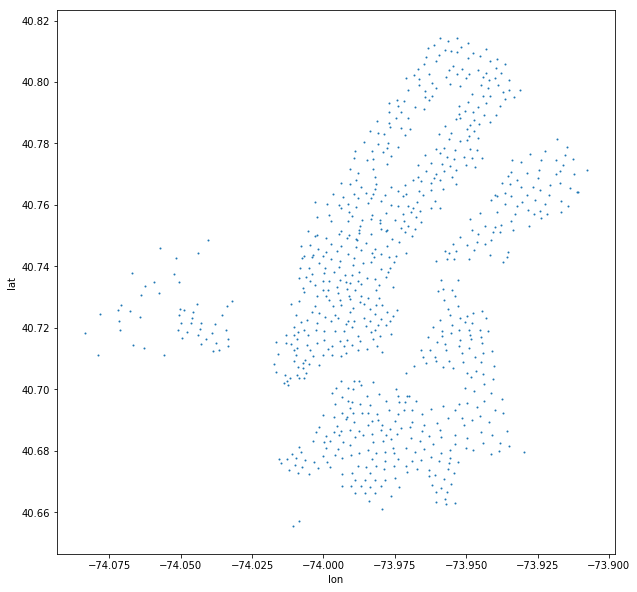

In [66]:
%matplotlib inline
check.plot(kind='scatter', x='lon', y='lat', s=1, figsize=(10,10))

In [67]:
results = requests.get(url_status).json() 
status = results["data"]["stations"]
status[0]

{'station_id': '304',
 'num_bikes_available': 13,
 'num_ebikes_available': 0,
 'num_bikes_disabled': 3,
 'num_docks_available': 17,
 'num_docks_disabled': 0,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'last_reported': 1543961972,
 'eightd_has_available_keys': True,
 'eightd_active_station_services': [{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a'}]}

In [89]:
# Now we fetch the data about the time varying elements of the citibike stations
from datetime import datetime

query_template = '''INSERT OR IGNORE INTO Status(station_id, 
                                            num_bikes_available,
                                            num_ebikes_available,
                                            num_bikes_disabled,
                                            num_docks_available,
                                            num_docks_disabled,
                                            is_installed,
                                            is_renting,
                                            is_returning,
                                            last_reported) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)'''

for entry in status:
    station_id = int(entry['station_id'])
    num_bikes_available = entry['num_bikes_available']
    num_bikes_disabled = entry['num_bikes_disabled']
    num_ebikes_available = entry['num_ebikes_available']
    num_docks_available = entry['num_docks_available']
    num_docks_disabled = entry['num_docks_disabled']
    is_installed = entry['is_installed']
    is_renting = entry['is_renting']
    is_returning = entry['is_returning']
    last_reported = datetime.fromtimestamp(entry['last_reported']) 
                       
    print("Inserting station", station_id)
    query_parameters = (station_id, num_bikes_available, num_ebikes_available, num_bikes_disabled,
                        num_docks_available, num_docks_disabled, is_installed, is_renting,
                        is_returning, last_reported)
    con.execute(query_template, query_parameters)

con.commit()

Inserting station 304
Inserting station 359
Inserting station 402
Inserting station 3255
Inserting station 3443
Inserting station 72
Inserting station 79
Inserting station 82
Inserting station 83
Inserting station 119
Inserting station 120
Inserting station 127
Inserting station 128
Inserting station 143
Inserting station 144
Inserting station 146
Inserting station 150
Inserting station 151
Inserting station 157
Inserting station 161
Inserting station 164
Inserting station 167
Inserting station 168
Inserting station 173
Inserting station 174
Inserting station 195
Inserting station 212
Inserting station 216
Inserting station 217
Inserting station 223
Inserting station 228
Inserting station 229
Inserting station 232
Inserting station 236
Inserting station 237
Inserting station 238
Inserting station 239
Inserting station 241
Inserting station 242
Inserting station 243
Inserting station 244
Inserting station 245
Inserting station 247
Inserting station 248
Inserting station 249
Inserting st

In [90]:
check = pd.read_sql("SELECT * FROM Status", con=con)
check


,station_id,last_reported,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning
0,304,2018-12-04 22:19:32,13,0,3,17,0,1,1,1
1,359,2018-12-04 22:18:50,18,0,3,32,0,1,1,1
2,402,2018-12-04 22:19:56,15,0,2,22,0,1,1,1
3,3255,2018-12-04 22:20:09,14,0,3,2,0,1,1,1
4,3443,2018-12-04 22:18:30,11,0,1,29,0,1,1,1
5,72,2018-12-04 22:17:21,15,0,2,22,0,1,1,1
6,79,2018-12-04 21:55:25,26,0,0,7,0,1,1,1
7,82,2018-12-04 22:16:00,23,0,1,3,0,1,1,1
8,83,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
9,119,2018-12-04 22:08:39,11,0,0,7,1,1,1,1


In [73]:
con.close()